In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install transformers

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
# BASE_PATH = "/content/drive/My Drive/collab/MIMIC/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/MIMIC/"
INPUT_PATH = BASE_PATH+"/DATA/input/"
FEATURES_PATH = BASE_PATH+"/DATA/features/"
OUTPUT_PATH = BASE_PATH+"/DATA/results/"
TMP_PATH = BASE_PATH+"/DATA/processed/"

TUNE_OUTPUT_PATH = BASE_PATH+"/DATA/results_fine/"
TUNE_TMP_PATH = BASE_PATH+"/DATA/processed_fine/"


sys.path.append("/content/drive/My Drive/collab/TADAT/") 

#configs
N_SEEDS=8
N_VAL_SEEDS = 4
N_VAL_RUNS = 4
N_TASKS = 3
# N_TASKS = 50
# PLOT_VARS=["auroc","auprc","sensitivity","specificity"]
PLOT_VARS=["auroc","sensitivity"]
MODEL="BERT-POOL"
PLOT_VAR = "auroc"

GROUPS = { "GENDER": ["M","F"],   
         "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
}

CLASSIFIER = 'sklearn'
CLASSIFIER = 'torch'

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 13
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [60]:
from collections import defaultdict
from datetime import datetime
# import dill
import fnmatch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import os
from pdb import set_trace
import pandas as pd
import pickle
import pprint
import random
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import torch
import uuid
import time

#local
from tadat.pipeline import plots
import tadat.core as core


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Modeling 

In [ ]:
def train_classifier(X_train, Y_train, X_val, Y_val, 
                     init_seed, shuffle_seed=None, input_dimension=None):    
    if CLASSIFIER == "torch":        
        x = core.models.MyLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCEWithLogitsLoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "sklearn":
        x = SGDClassifier(loss="log", random_state=shuffle_seed)
        x.fit(X_train, Y_train)
    else:
        raise NotImplementedError
    return x

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, subgroup, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    if CLASSIFIER == 'sklearn':
        Y_hat_prob = Y_hat_prob[:,labels[1]]    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    try:
        aurocc = roc_auc_score(Y_test, Y_hat_prob)
    except ValueError:
        aurocc = 0
    try:
        prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat_prob)       
        auprc = auc(rec, prec)
    except ValueError:
        auprc = 0
    try:
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (fn+tp)
    except ValueError:
        specificity, sensitivity = 0, 0
    
    res = {"model":model_name, 
            "seed":random_seed,  
            "group":subgroup,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        core.helpers.save_results(res, res_path, sep="\t")
    return res

def tune_classifier(train_X, train_Y, val_X, val_Y, label_vocab, 
                    feature_type, seeds, metric):
    best_model = None
    best_perf = -1
    best_seed = None
    runs = {}    
    #all seed pairs
    for init_seed, shuffle_seed in itertools.product(seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)    
        model = train_classifier(train_X, train_Y,
                                     val_X, val_Y, init_seed=init_seed,
                                     shuffle_seed=shuffle_seed, 
                                     input_dimension=train_X.shape[1])
        
        res = evaluate_classifier(model, val_X, val_Y, 
                                  label_vocab, feature_type, seed, subgroup="val")
        try:
            perf = res[metric]
        except KeyError:
            raise KeyError("Metric {} Unknown".format(metric))
        
        runs[seed] = perf
        if perf > best_perf:
            best_perf = perf
            best_model = model
            best_seed = seed
    return best_model, best_perf, best_seed, runs

def vectorize_train(df_train, df_val, subject_ids):
    #vectorize labels
    train_Y = df_train["Y"]
    val_Y = df_val["Y"]           
    
    label_vocab = core.vectorizer.get_labels_vocab(train_Y+val_Y)
    train_Y,_ = core.vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = core.vectorizer.label2idx(val_Y, label_vocab)
    
    #get the subject id indices
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    val_idxs = [subject_ids.index(i) for i in list(df_val["SUBJECT_ID"])] 

    return train_idxs, train_Y, val_idxs, val_Y, label_vocab

def vectorize_test(df_test, subject_ids, label_vocab):    
    subgroup_idxs = defaultdict(dict)             
    #vectorize labels               
    test_Y,_ = core.vectorizer.label2idx(df_test["Y"], label_vocab)   
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    subgroup_idxs["all"] = [test_idxs, test_Y]
    for group in list(GROUPS.keys()):
        #and subgroups
        for subgroup in GROUPS[group]:                
            df_subgroup = df_test[df_test[group] == subgroup]
            print("[subgroup: {} | size: {}]".format(subgroup, len(df_subgroup)))
            #vectorize labels               
            test_Y_G,_ = core.vectorizer.label2idx(df_subgroup["Y"], label_vocab)            
            #get indices into the feature matrix
            idxs = [subject_ids.index(i) for i in list(df_subgroup["SUBJECT_ID"])] 
            if subgroup == "M":
                subgroup = "men"
            elif subgroup == "F":
                subgroup = "women"
            subgroup_idxs[subgroup.lower()] = [idxs, test_Y_G]

    return test_idxs, test_Y, subgroup_idxs

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = core.features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = core.features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = core.features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = core.features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        X =  core.transformer_encoders.transformer_encode_sequences(data, batchsize=64)        
    elif feature_type == "BERT-CLS":
        X =  core.transformer_encoders.transformer_encode_sequences(data, cls_features=True,
                                                        batchsize=64)        
    elif feature_type == "MULTI-BERT-POOL":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "MULTI-BERT-CLS":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, 
                                                         cls_features=True,
                                                         batchsize=32,
                                                         tmp_path=TMP_PATH)
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, path):
    X = read_cache(path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        print("[computing {} features]".format(feature_type))
        df = pd.read_csv(path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = core.vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        #save features
        print("[saving features]")
        write_cache(path+"feats_{}".format(feature_type), 
                    [subject_ids, X_feats])
    return subject_ids, X_feats



# Run

In [ ]:
def read_dataset(path, dataset_name, df_patients):    
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), 
                           sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name),
                           sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name),
                           sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)

    df_train = df_train.join(df_patients, on="SUBJECT_ID", 
                             how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", 
                           how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", 
                         how="inner", lsuffix="N_").reset_index()

    return df_train, df_test, df_val   


def read_cache(path):
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path, "wb") as fo:
        pickle.dump(o, fo)
        
def clear_cache(cache_path, model="*", dataset="*", group="*", ctype="*"):
    assert ctype in ["*","res*","feats"]
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_{}_*_{}.pkl".format(dataset, model, group, ctype).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            os.remove(cache_path+"/"+fname)
            print("cleared file: {}".format(fname))      

def run(data_path, dataset, features_path, feature_type, cache_path):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)
    train_idx, train_Y, val_idx, val_Y, label_vocab = vectorize_train(df_train, 
                                                                       df_val, 
                                                                       subject_ids)
    test_idxs, test_Y, subgroup_idxs = vectorize_test(df_test, subject_ids, label_vocab) 
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]
    test_X = feature_matrix[test_idxs,:]
    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), N_SEEDS)        
    incremental_results = {} 
    test_sets = {}
    ##train/test classifier for each random seed pair
    for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)
        res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = {}
            print(" > seed: {}".format(seed))                        
            model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                     input_dimension=train_X.shape[1],
                                     init_seed=init_seed, 
                                     shuffle_seed=shuffle_seed)                                                      
            #test each subgroup (note thtat *all* is also a subgroup)
            for subgroup in subgroup_idxs.keys():                                
                test_idx_G, test_Y_G = subgroup_idxs[subgroup]                 
                test_X_G = feature_matrix[test_idx_G, :]                
                res_g = evaluate_classifier(model, test_X_G, test_Y_G, 
                                            label_vocab, feature_type, seed, subgroup)                
                curr_results[subgroup]= res_g               
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | seed: {}".format(seed))        
        
        incremental_results = merge_results(curr_results, incremental_results, 
                                            list(subgroup_idxs.keys()))
    #build dataframes 
    df_results = results_to_df(incremental_results, subgroup_idxs.keys())
    return df_results

def tune_run(data_path, dataset, features_path, feature_type, cache_path, tune_metric):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)
    train_idx, train_Y, val_idx, val_Y, label_vocab = vectorize_train(df_train, 
                                                                       df_val, 
                                                                       subject_ids)
    test_idxs, test_Y, subgroup_idxs = vectorize_test(df_test, subject_ids, label_vocab) 
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]
    test_X = feature_matrix[test_idxs,:]
    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), N_VAL_RUNS*N_VAL_SEEDS)        
    incremental_results = {} 
    test_sets = {}    
    
    for i in range(N_VAL_RUNS):        
        res_fname = "{}_{}_tuned_res{}.pkl".format(dataset, feature_type, i).lower()
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = {}
            seeds = random_seeds[i*N_VAL_SEEDS:(i+1)*N_VAL_SEEDS]
            model, perf, best_seed, val_run = tune_classifier(train_X, train_Y, 
                                                              val_X, val_Y, label_vocab,
                                                              feature_type, seeds, tune_metric)               
            print("[seed: {}| {}: {}]".format(best_seed, tune_metric, perf))    
                                                    
            #test each subgroup (note thtat *all* is also a subgroup)
            for subgroup in subgroup_idxs.keys():                                
                test_idx_G, test_Y_G = subgroup_idxs[subgroup]                 
                test_X_G = feature_matrix[test_idx_G, :]                
                res_g = evaluate_classifier(model, test_X_G, test_Y_G, 
                                            label_vocab, feature_type, best_seed, subgroup)                
                curr_results[subgroup]= res_g               
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | run: {}".format(i))        
        
        incremental_results = merge_results(curr_results, incremental_results, 
                                            list(subgroup_idxs.keys()))
    #build dataframes 
    df_results = results_to_df(incremental_results, subgroup_idxs.keys())
    return df_results

def merge_results(curr_results, results, subgroups):
    #append results    
    for subgroup in subgroups:                
        res = curr_results[subgroup]
        try:
            results[subgroup].append(res)            
        except KeyError:
            results[subgroup] = []
            results[subgroup].append(res)            
    return results

def results_to_df(results, subgroups):
    df_results = {}
    df_res = pd.DataFrame(results["all"])            
    for subgroup in subgroups:        
        # if subgroup == "all": continue
        df_res_g = pd.DataFrame(results[subgroup])        
        df_res_delta = df_res_g.sub(df_res.iloc[:,3:])
        # from pdb import set_trace; set_trace()
        df_res_delta["model"] = df_res_g["model"]
        df_res_delta["seed"] = df_res_g["seed"]
        df_res_delta["group"] = df_res_g["group"] 
        df_results[subgroup] = {}
        df_results[subgroup]["results"] = df_res_g
        df_results[subgroup]["delta"] = df_res_delta
        
    return dict(df_results)



# Analyses

In [54]:
def run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                 cache_path, clear_results=False, tune_metric=None, plot_metric="auroc"):    

    if clear_results:
        clear_cache(cache_path, model=feature_type, dataset=dataset, ctype="res*")
    if tune_metric:                              
        df_results = tune_run(data_path, dataset, features_path, feature_type, cache_path, tune_metric)  
        fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:
        df_results = run(data_path, dataset, features_path, feature_type, cache_path)         
        fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()
        
    #save results
    if not os.path.exists(results_path): os.makedirs(results_path)  
    write_cache(results_path+fname, df_results)
    if plot_metric:           
        plot_scatters(df_results, plot_metric, dataset)
        plot_deltas(df_results, plot_metric, dataset)
    return df_results               

#Run All the tasks
def run_tasks(data_path, tasks_fname, features_path, feature_type, results_path, cache_path,  
             reset=False, tune_metric=None, plot_metric=None, mini_tasks=True):
    #if reset delete the completed tasks file
    if reset: reset_tasks(cache_path)    
    with open(data_path+tasks_fname,"r") as fid:
        for i,l in enumerate(fid):
            if i > N_TASKS: break
            fname, task_name = l.strip("\n").split(",")            
            dataset = "mini-"+fname if mini_tasks else fname
            # dataset = fname
            if is_task_done(cache_path, dataset): 
                print("[dataset: {} already processed]".format(dataset))
                continue                        
            print("******** {} {} ********".format(task_name, dataset))      
            run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                         cache_path, clear_results=False, tune_metric=tune_metric, 
                         plot_metric=plot_metric)
            task_done(cache_path, dataset)

def task_done(path,  task):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "a") as fod:
        fod.write(task+"\n")

def reset_tasks(path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "w") as fod:
        fod.write("")

def is_task_done(path,  task):
    try:
        with open(path+"completed_tasks.txt", "r") as fid:
            tasks = fid.read().split("\n")            
        return task in set(tasks)
    except FileNotFoundError:
        #create file if not found
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(path+"completed_tasks.txt", "w") as fid:
            fid.write("")
        return False

def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass

def plot_scatters(results, metric, title):
    n_rows=2
    n_cols = 3    
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=(12,5), sharex=True, sharey=True)
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))   
    subgroups = list(results.keys())
    subgroups.remove('all')
    df = results['all']["results"]
    for subgroup, col, coord in zip(subgroups, cmap, coords ):
        df_delta = results[subgroup]["delta"]        
        df_all = df.merge(df_delta, on=["model","seed"],
                                      suffixes=[None, "_delta"])
        #get absolute values for the deltas    
        df_all[metric+"_delta"] = df_all[metric+"_delta"].abs() 
        df_all.plot.scatter(x=metric,y=metric+"_delta",
                            c=col, ax=ax[coord[0]][coord[1]])
        ax[coord[0]][coord[1]].set_title(subgroup)
        ax[coord[0]][coord[1]].set_ylabel("delta")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    
def plot_deltas(results, metric, title):
    df_delta = pd.concat([results[g]["delta"] for g in list(results.keys()) if g != "all"])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], 
                                  value_vars=[metric], 
                                  var_name="metric", value_name="delta")
    g = sns.catplot(x="group", y="delta", data=df_delta_long, 
                    sharey=True,legend=False)    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  

def plot_analyses(results_path, dataset, task_name, feature_type, plot_metric, tune_metric=None):
    if tune_metric:
        fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:        
        fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

    df_results = read_cache(results_path+fname)
    if df_results:
        plot_scatters(df_results, plot_metric, task_name)
        plot_deltas(df_results, plot_metric, task_name)


def plot_tasks(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            plot_analyses(results_path, dataset, task_name, feature_type, plot_metric, tune_metric)

    plot_gaps(tasks_fname, feature_type, results_path, mini_tasks=mini_tasks, 
              plot_metric=plot_metric, tune_metric=tune_metric)
    plot_performances(tasks_fname, feature_type, results_path, mini_tasks=mini_tasks, 
              plot_metric=plot_metric, tune_metric=tune_metric)

def get_gaps(results, dataset_name, metric):    
    all_dfs = [results[g]["results"][["seed", metric]] for g in results.keys()]
    all_dfs = pd.concat(all_dfs)
    diff_df = (all_dfs.groupby("seed").max() - all_dfs.groupby("seed").min()).reset_index()
    diff_df["dataset"] = [dataset_name]*len(diff_df)
    return diff_df

def plot_gaps(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    
            if df_results:
                df_gaps = get_gaps(df_results, task_abv, plot_metric)
                dfs.append(df_gaps)
    dfs = pd.concat(dfs)
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = sns.catplot(x=plot_metric,y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6, aspect=0.85,palette=cmap)        
    g.set_xlabels(plot_metric + " gap")
    plt.tight_layout()
    plt.show()  
    
def plot_performances(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    
            if df_results:
                df = df_results["all"]["results"]
                df["dataset"] = [task_abv]*len(df)
                dfs.append(df)
    dfs = pd.concat(dfs)
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = sns.catplot(x=plot_metric,y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6, aspect=0.85,palette=cmap)        
#     g.set_xlabels(plot_metric + " gap")
    plt.tight_layout()
    plt.show()  

# Main

In [ ]:
dataset="IHM"
dataset="mini-"+dataset
CLASSIFIER="torch"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, 
             clear_results=False, tune_metric=TUNE_METRIC, plot_metric=PLOT_VAR)
plot_analyses(OUTPUT_PATH, dataset, MODEL, plot_metric=PLOT_METRIC, tune_metric=TUNE_METRIC)


In [ ]:
CLASSIFIER="torch"
# run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, clear_results=False, tune_metric=None, subsample=False, plots=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, tune_metric=None)

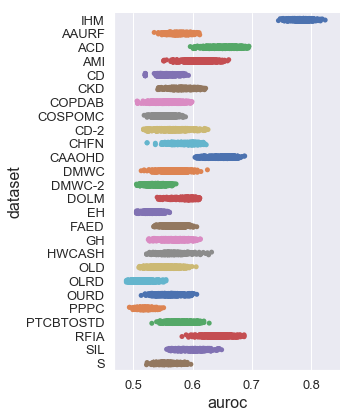

In [53]:
plot_performances(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

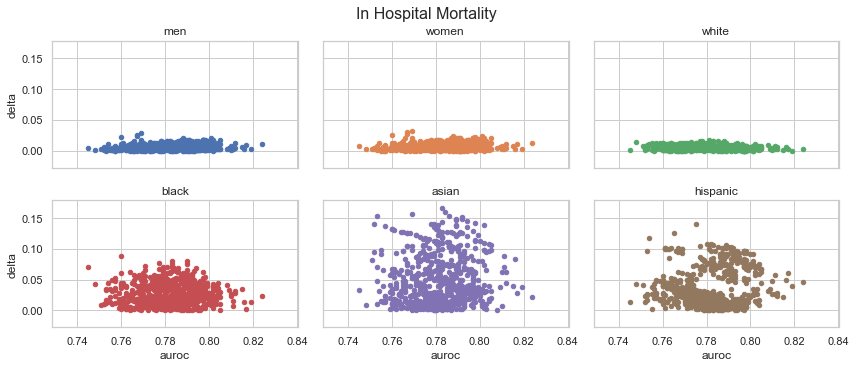

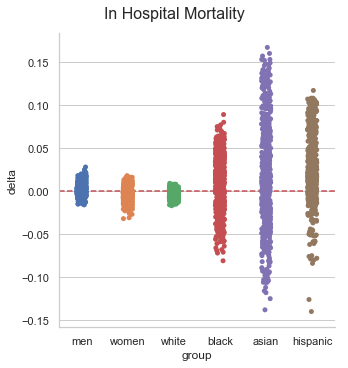

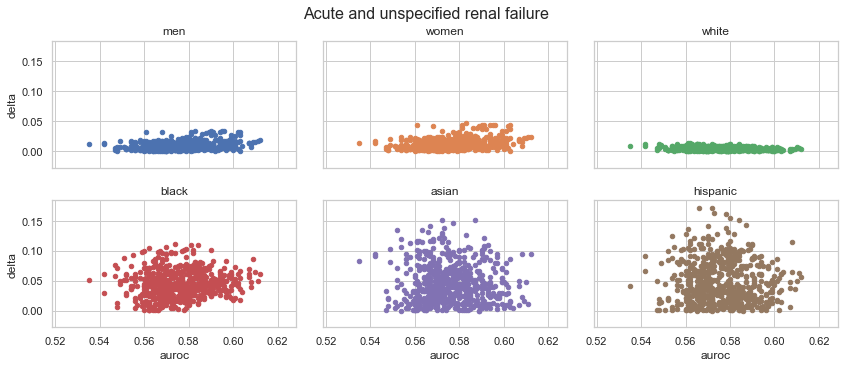

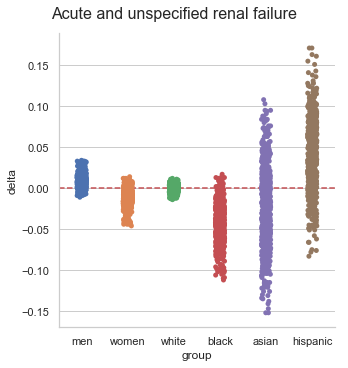

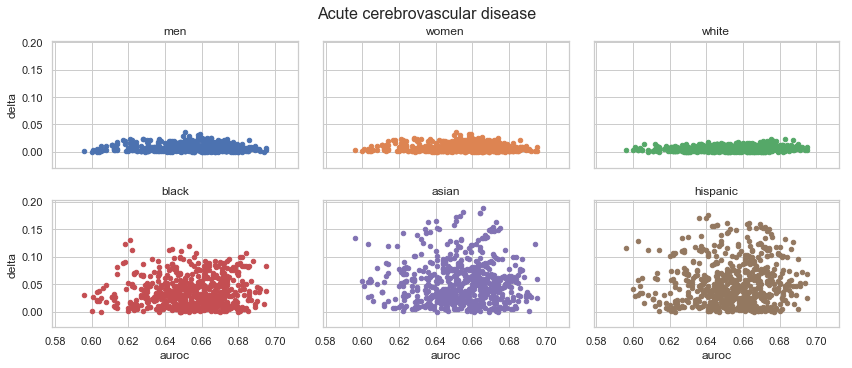

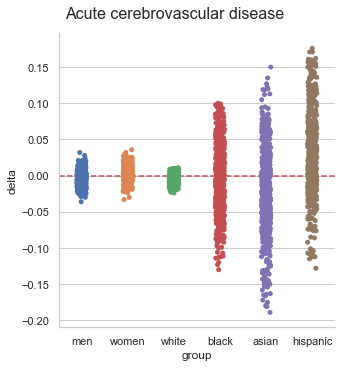

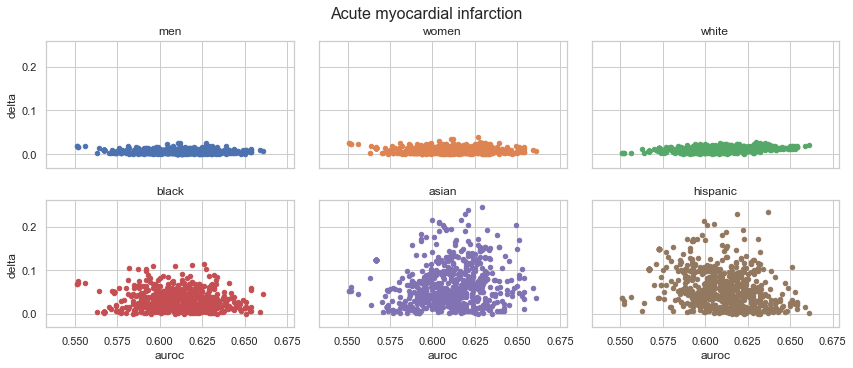

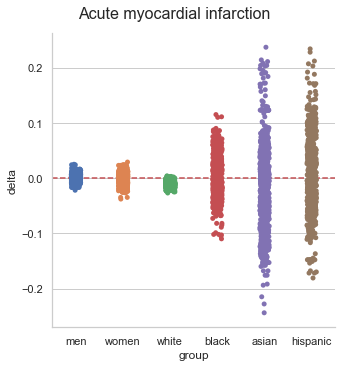

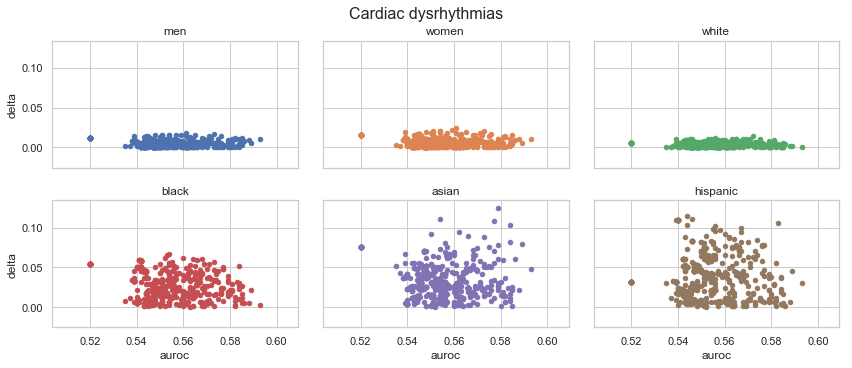

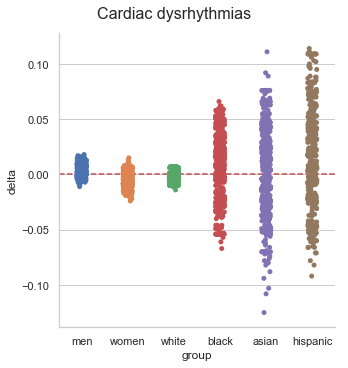

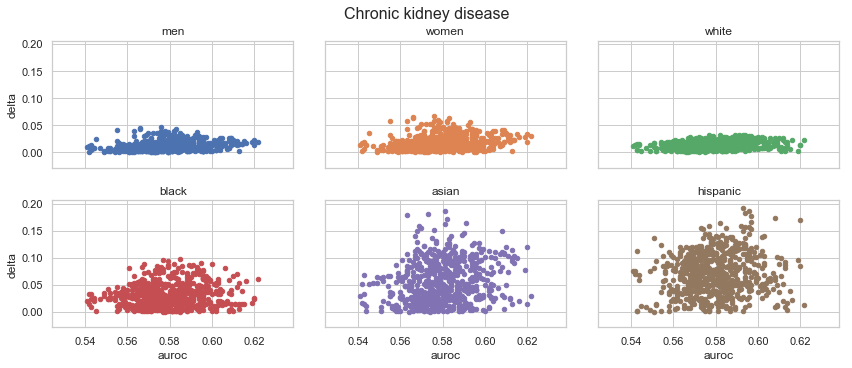

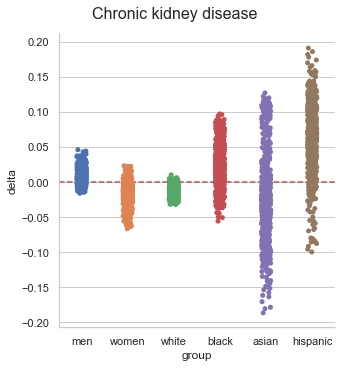

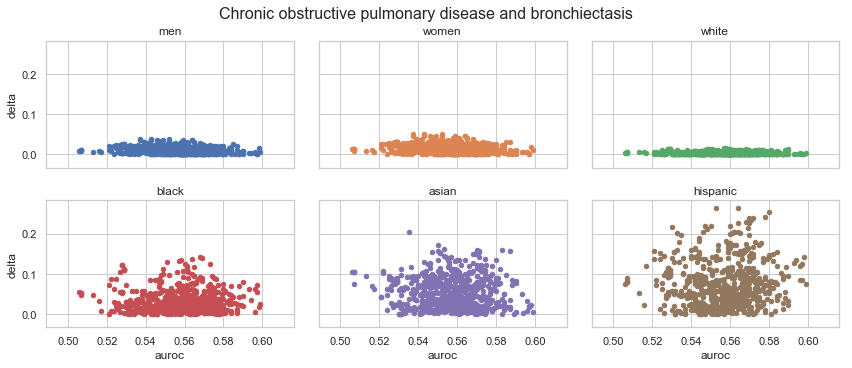

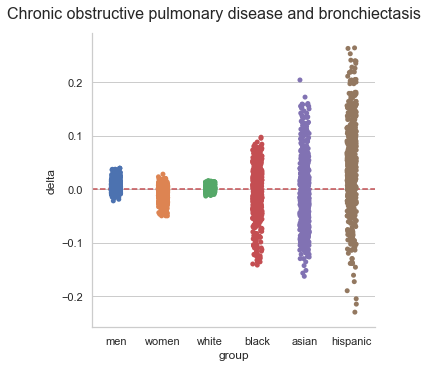

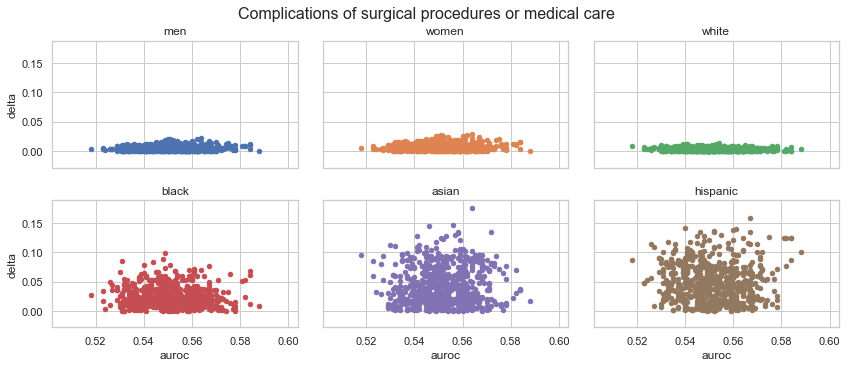

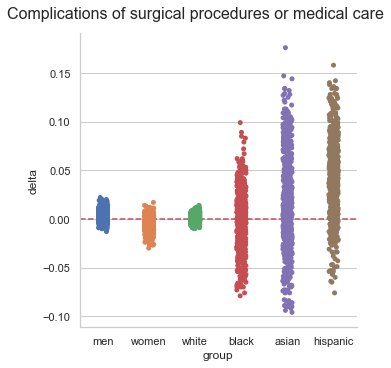

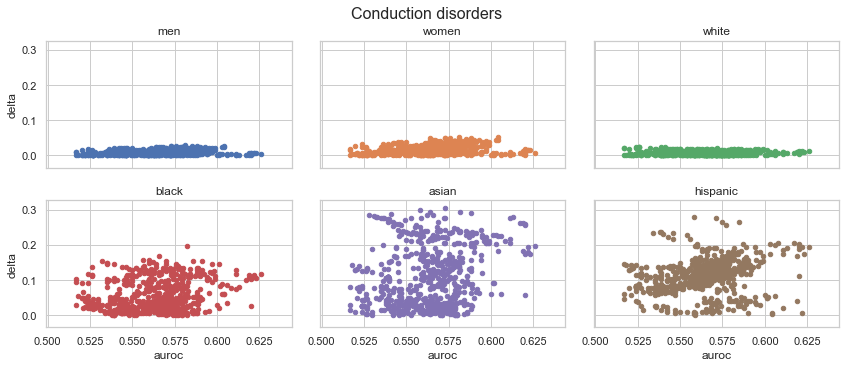

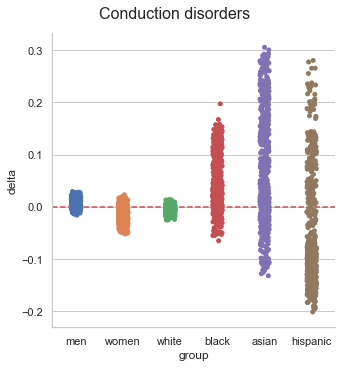

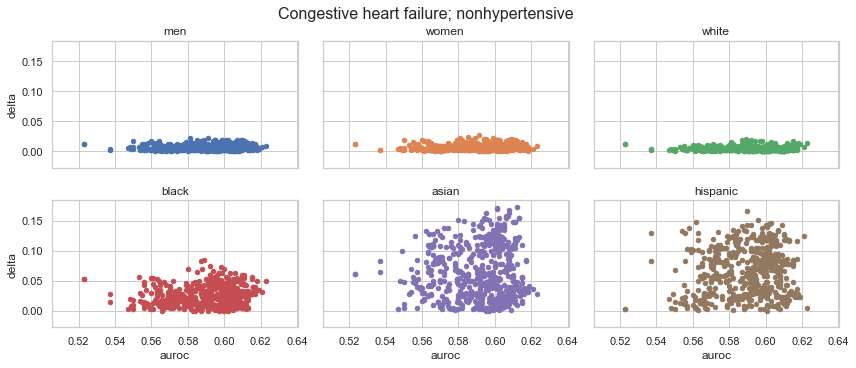

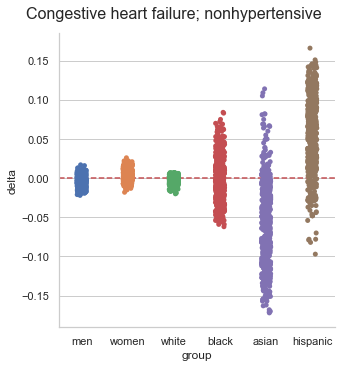

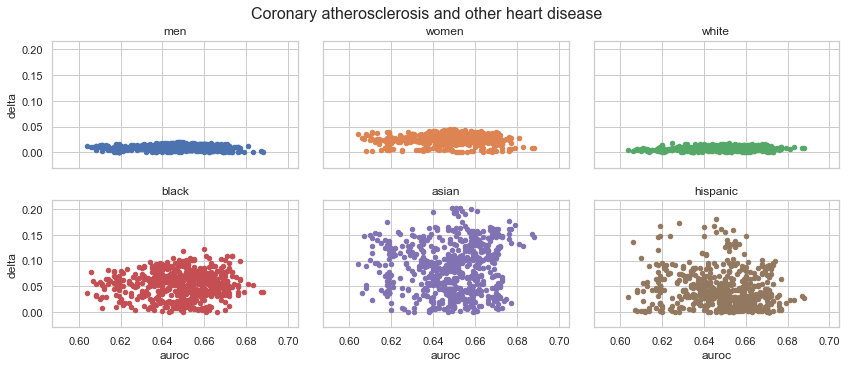

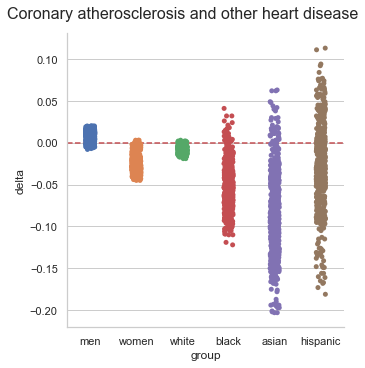

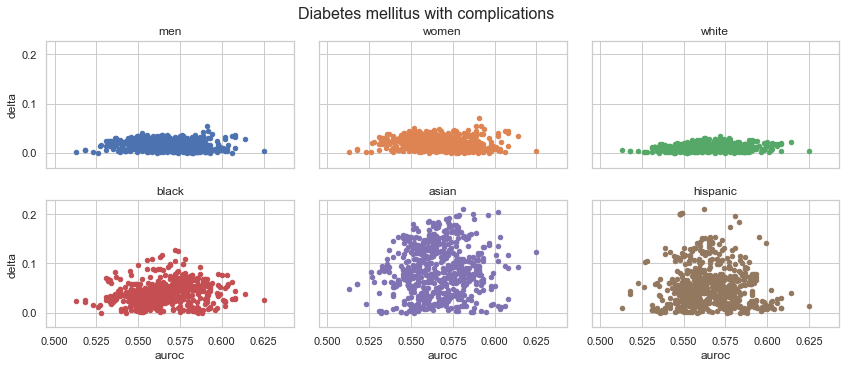

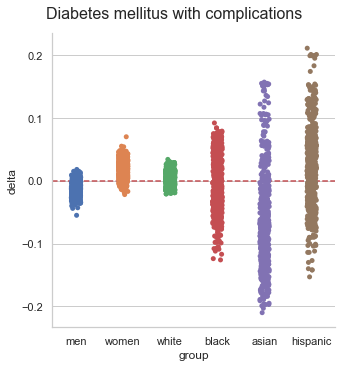

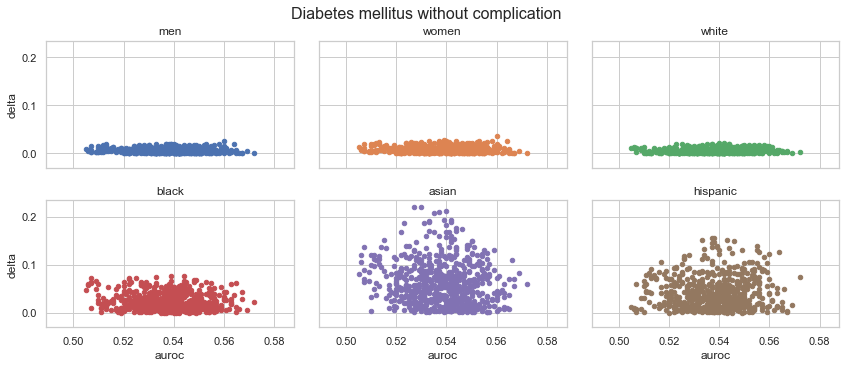

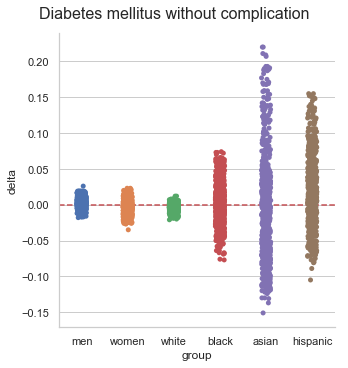

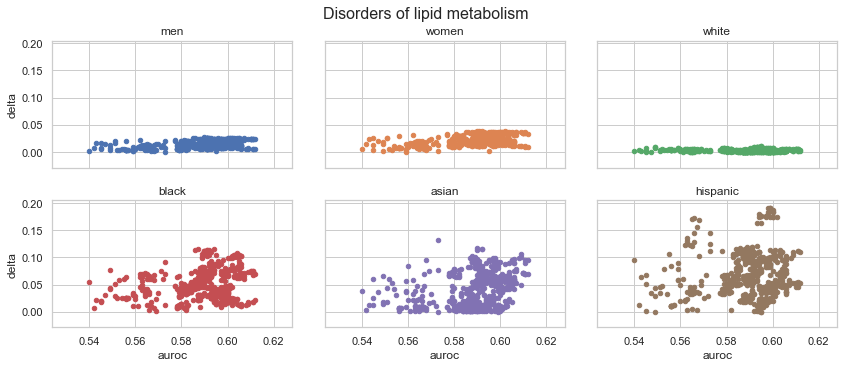

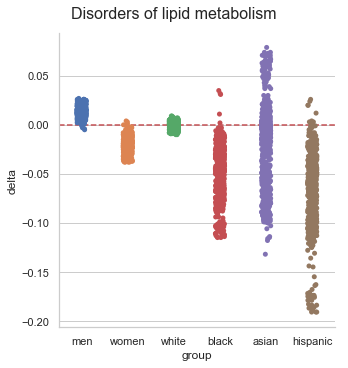

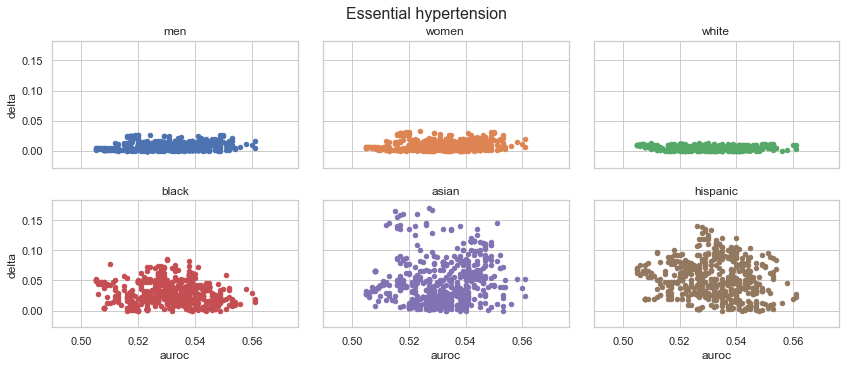

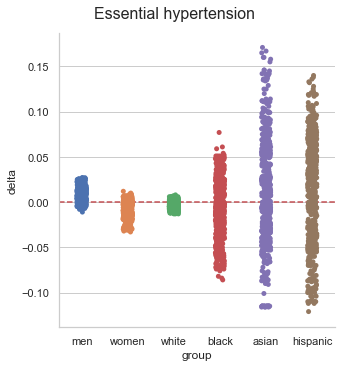

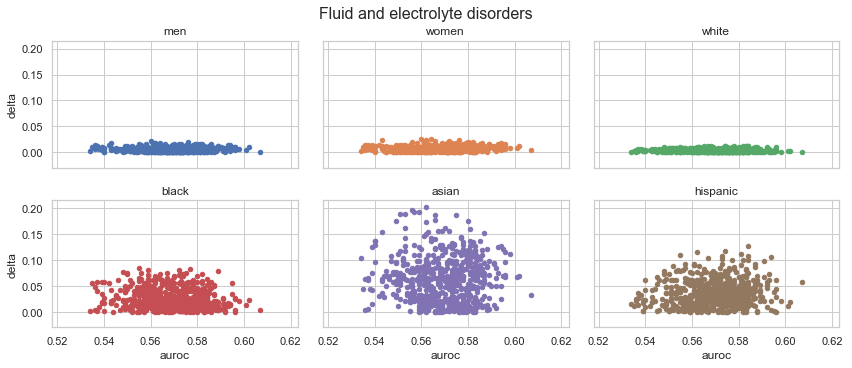

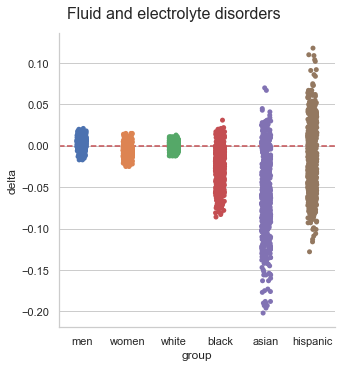

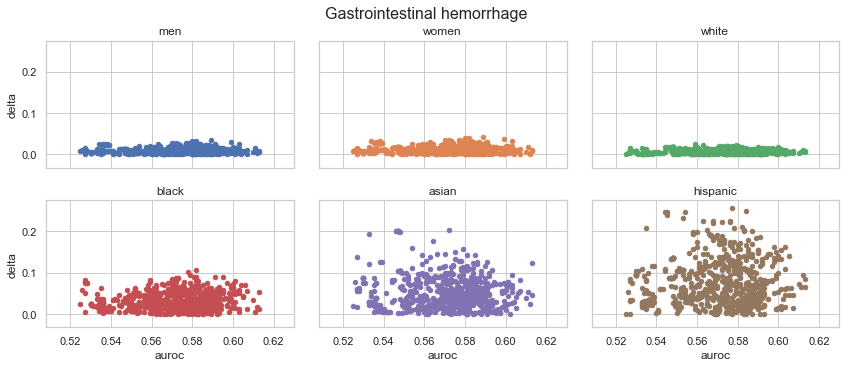

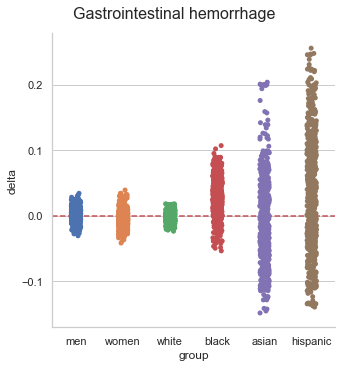

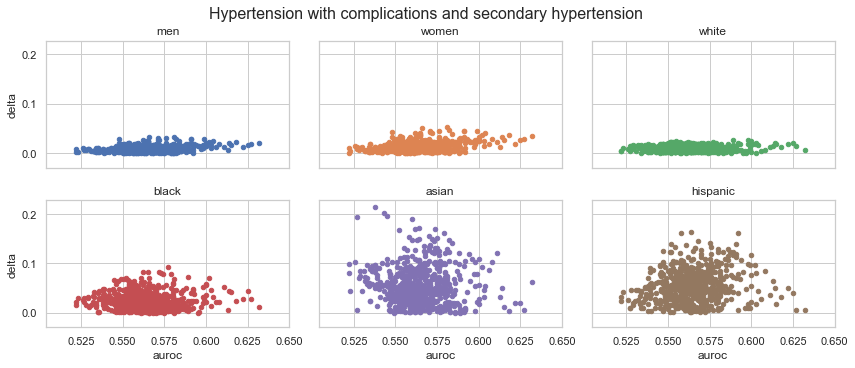

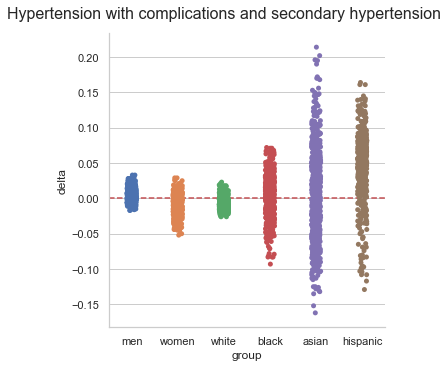

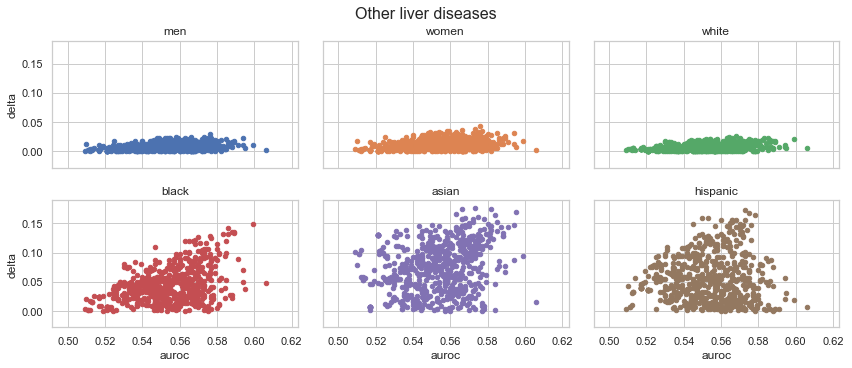

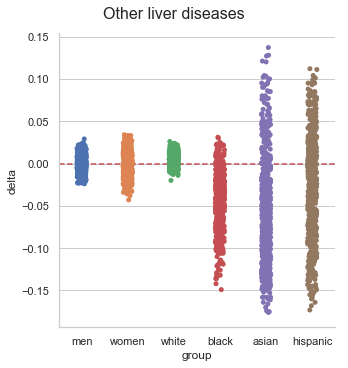

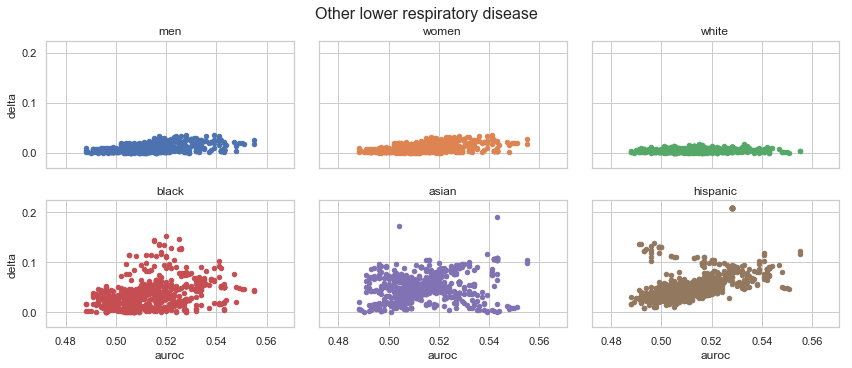

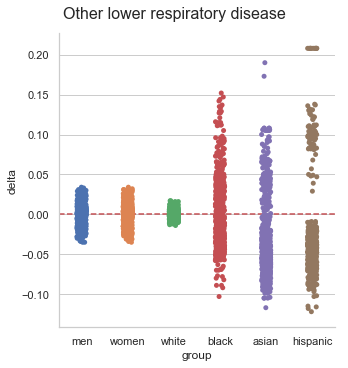

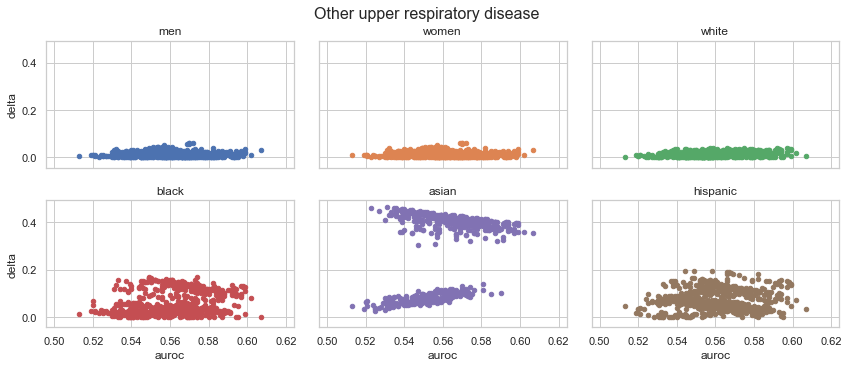

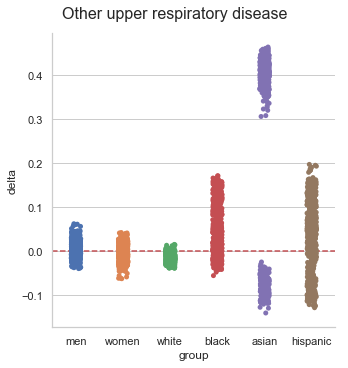

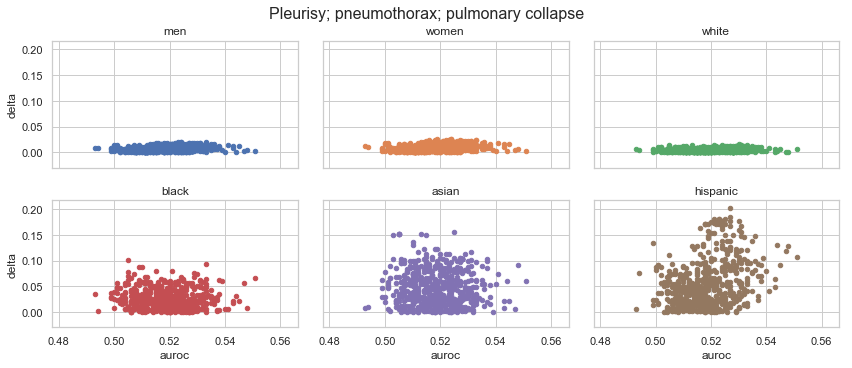

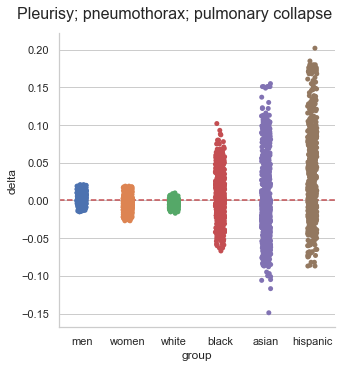

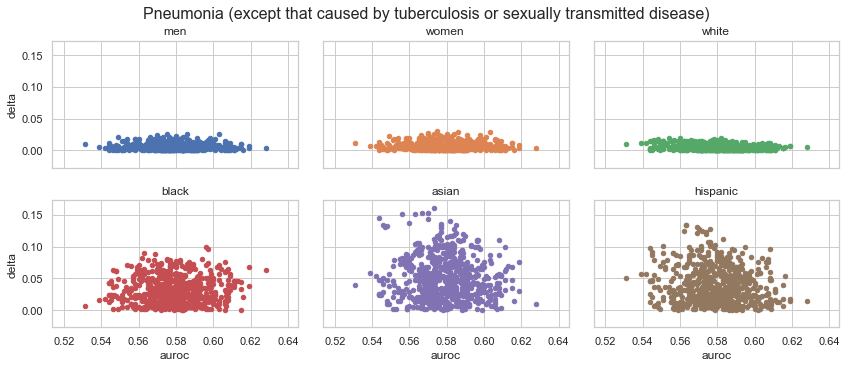

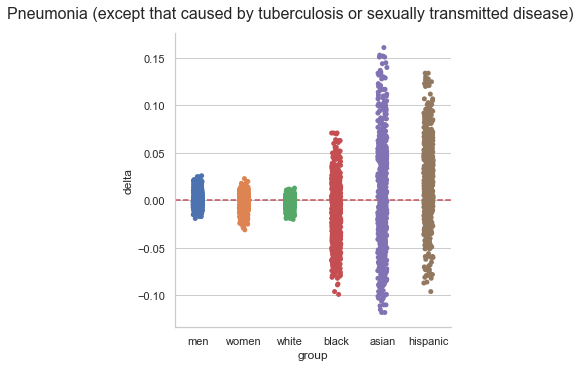

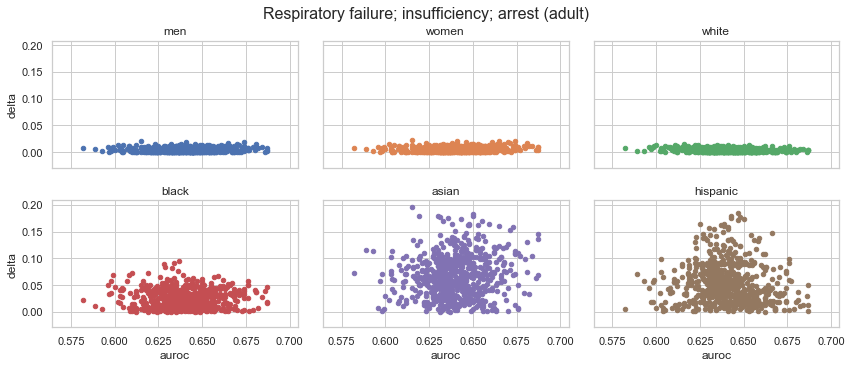

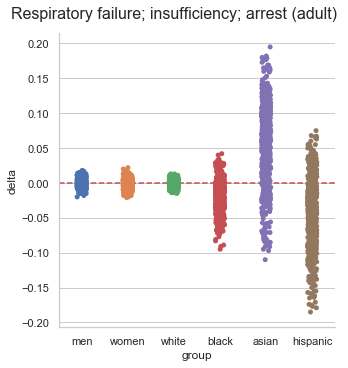

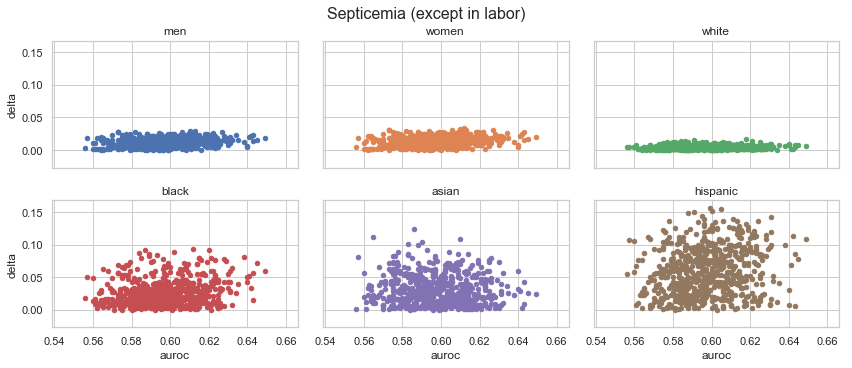

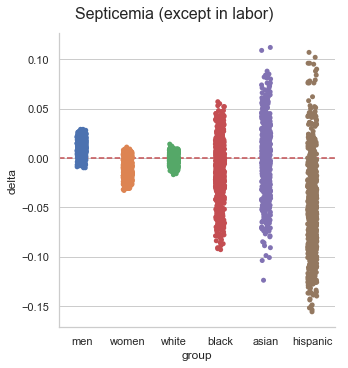

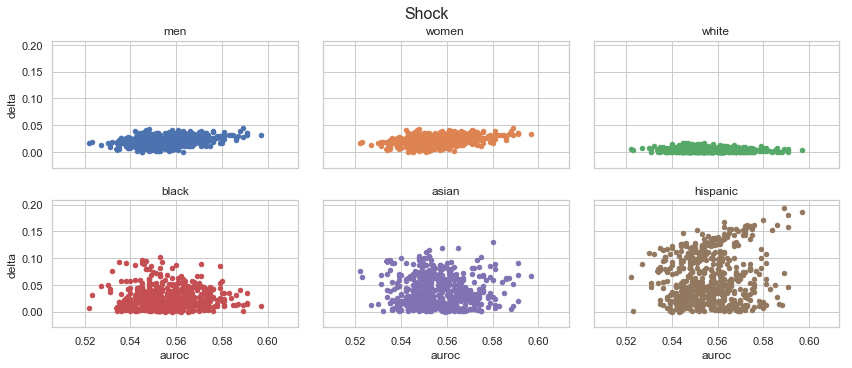

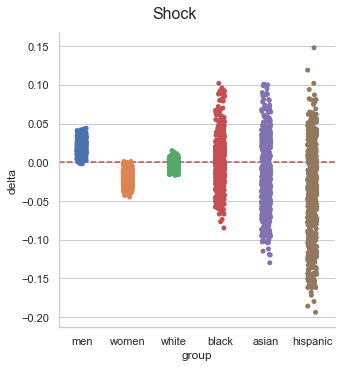

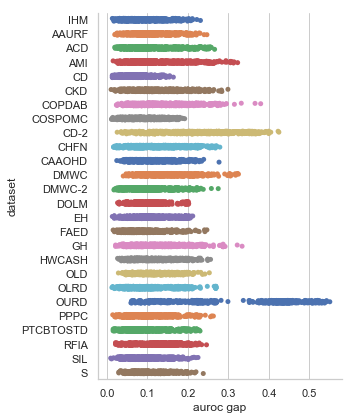

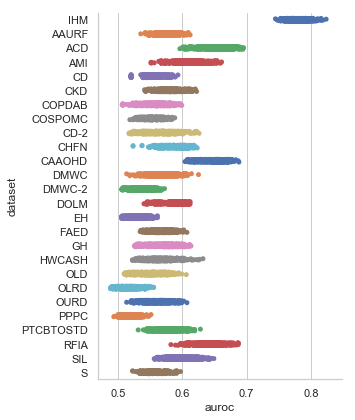

In [61]:
#Run tasks
# run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
#           tune_metric=None, plot_metric=None, mini_tasks=True)
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

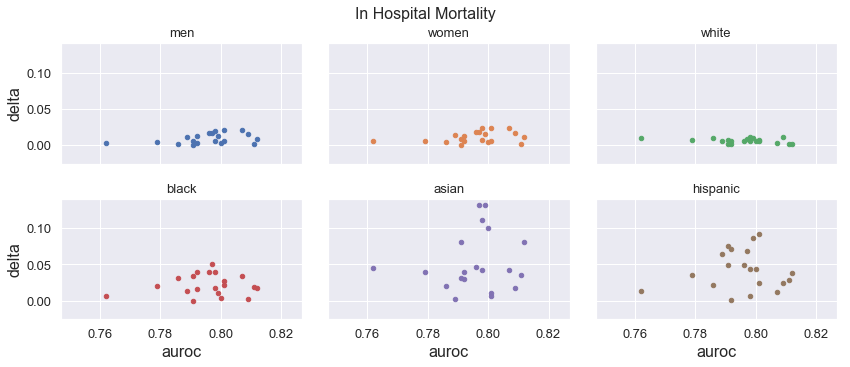

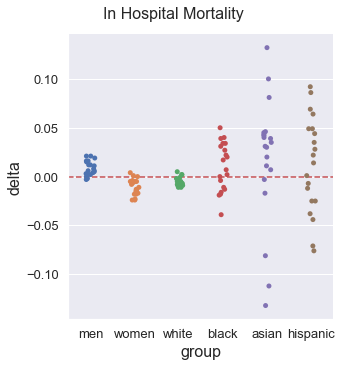

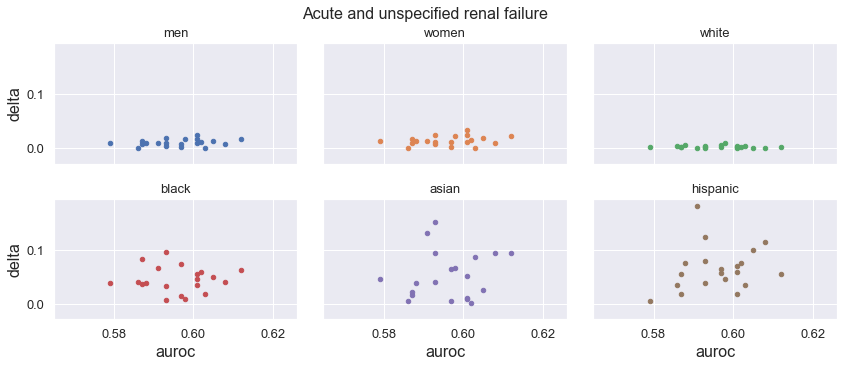

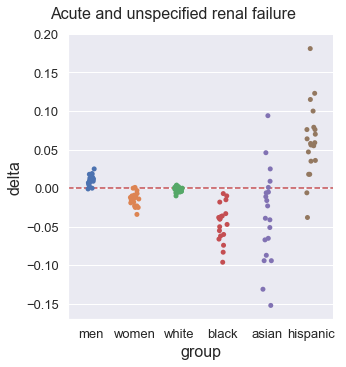

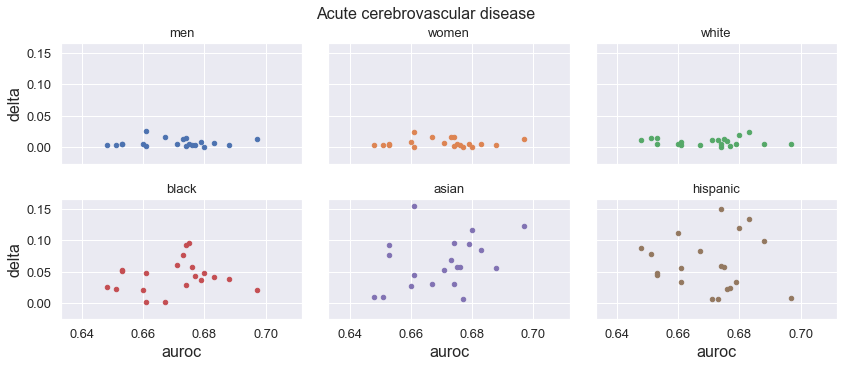

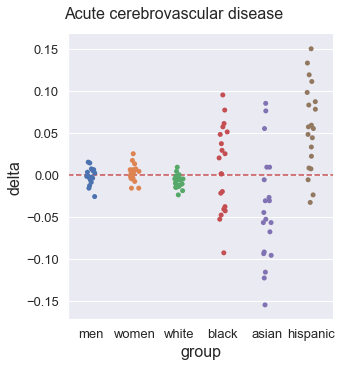

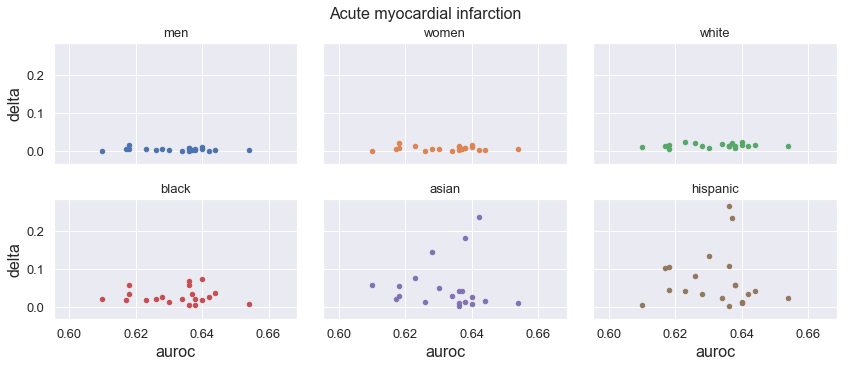

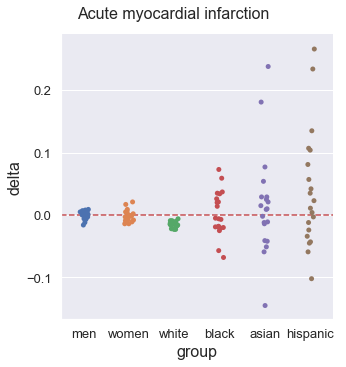

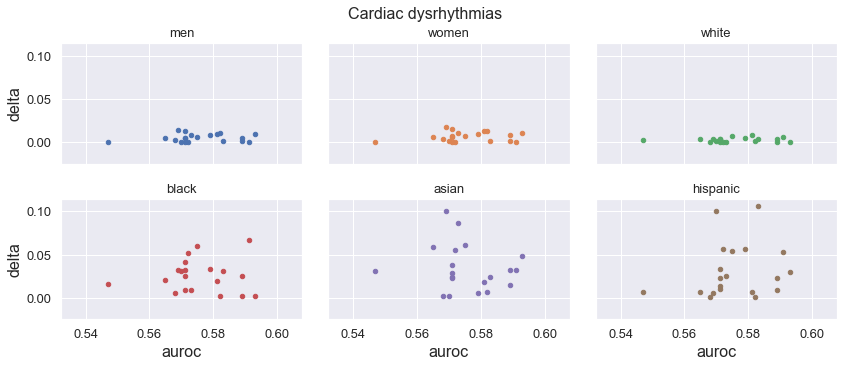

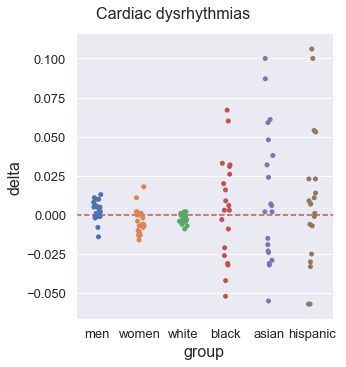

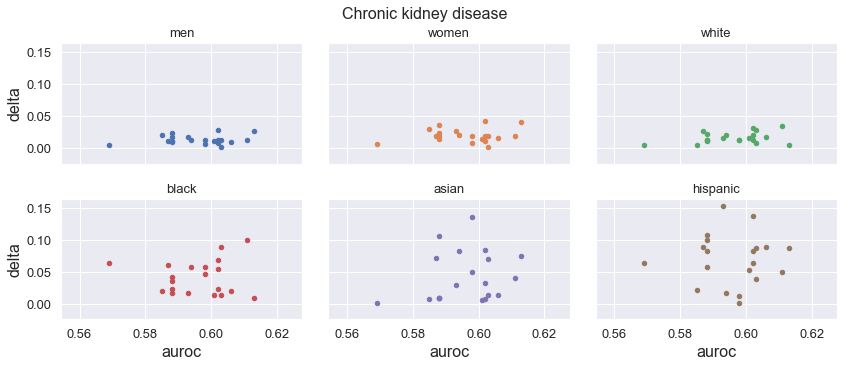

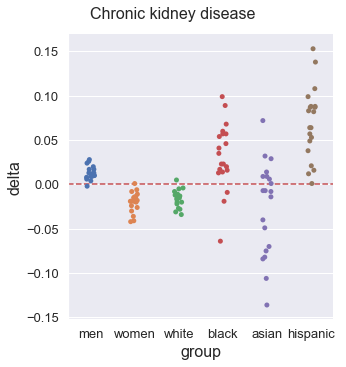

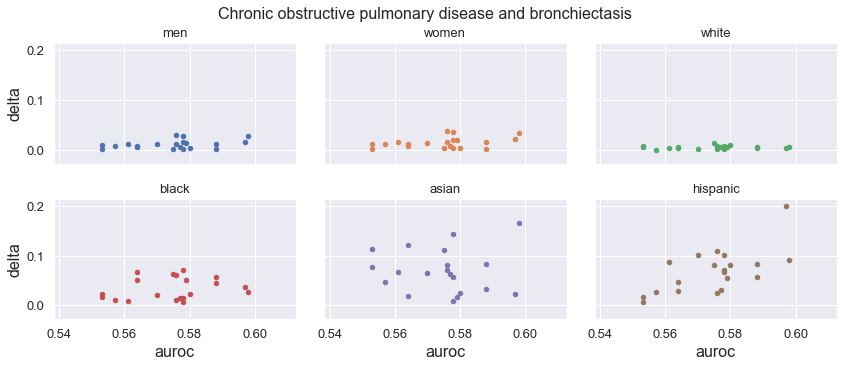

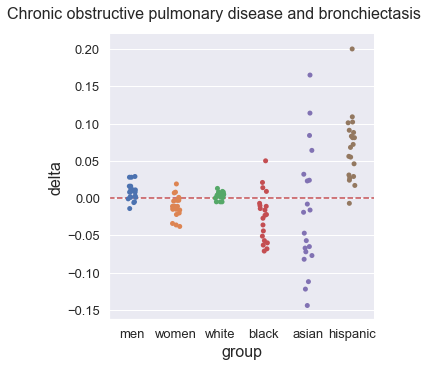

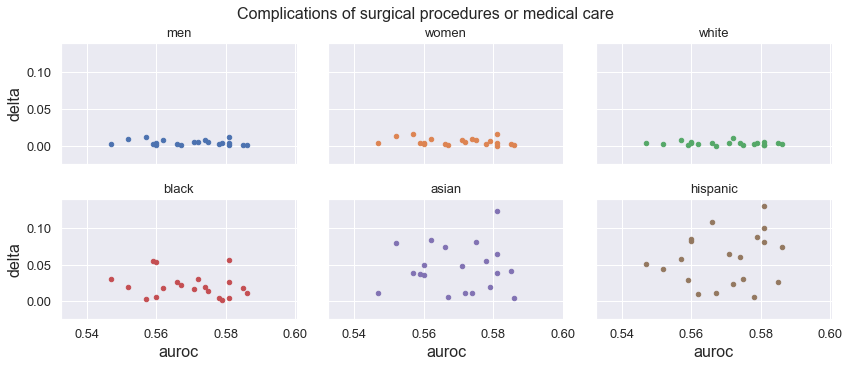

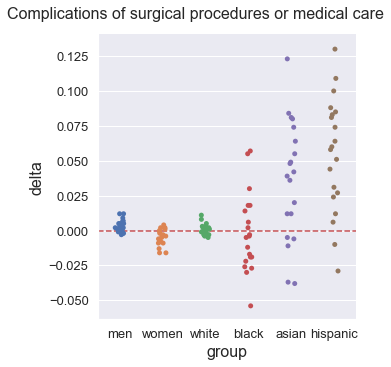

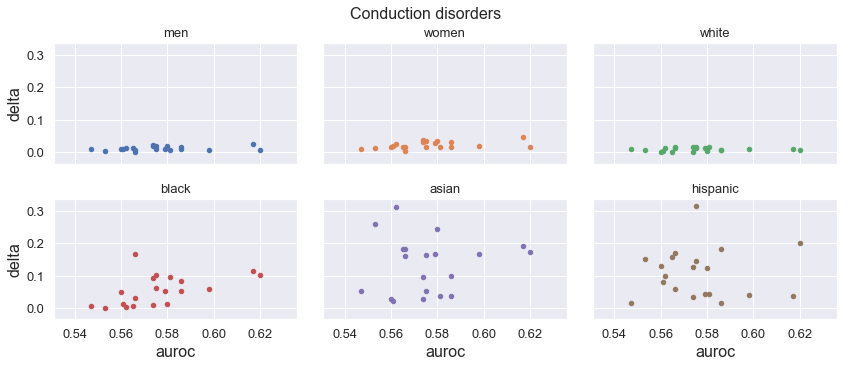

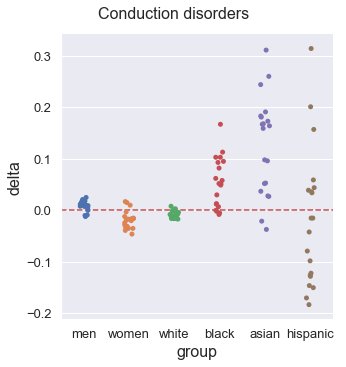

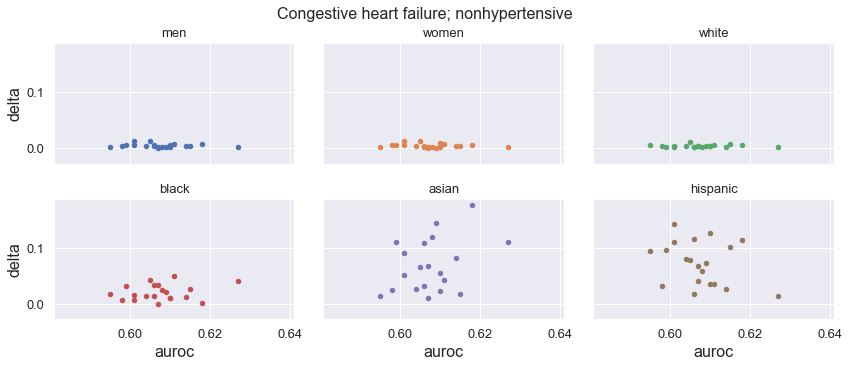

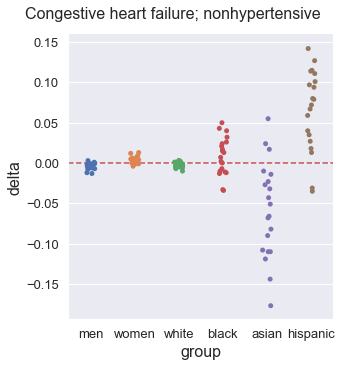

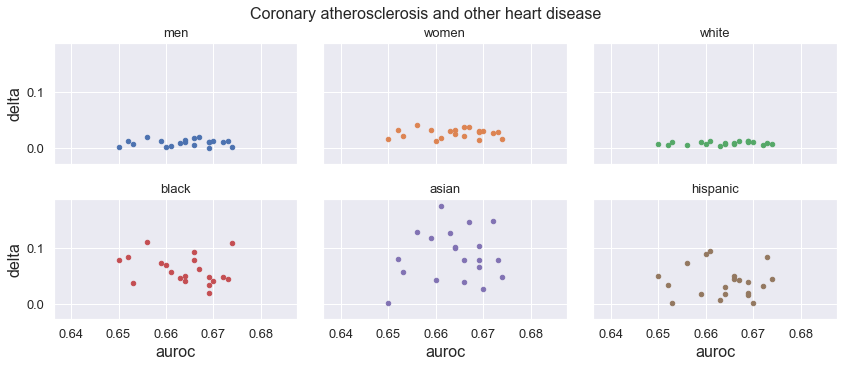

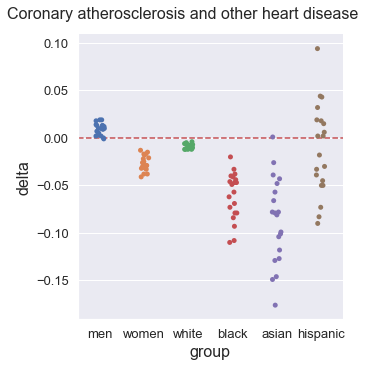

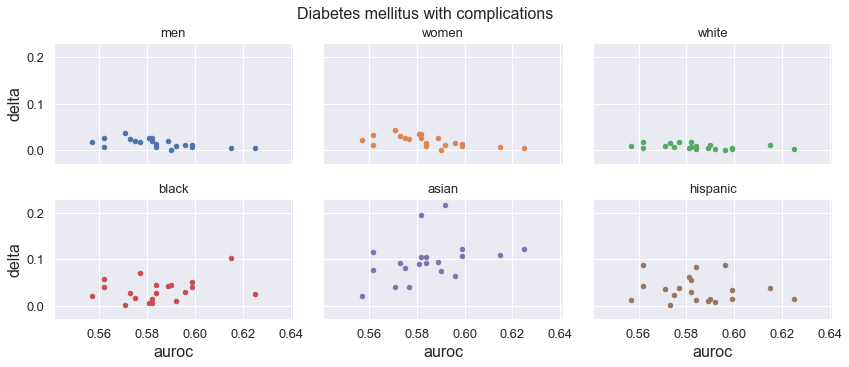

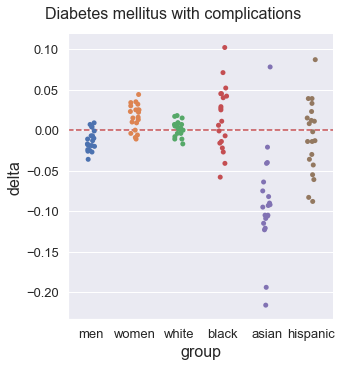

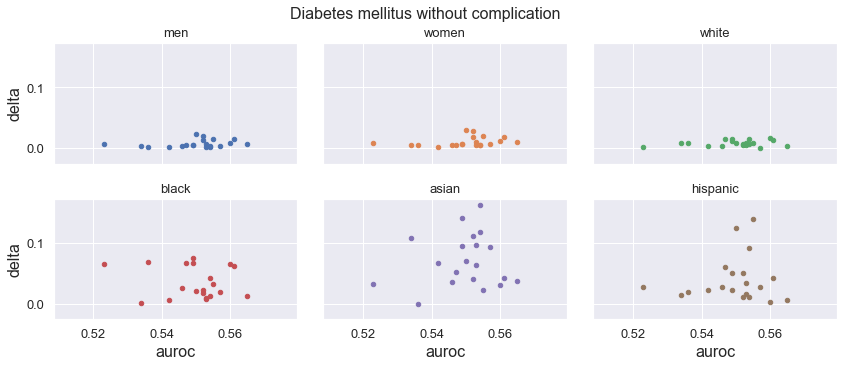

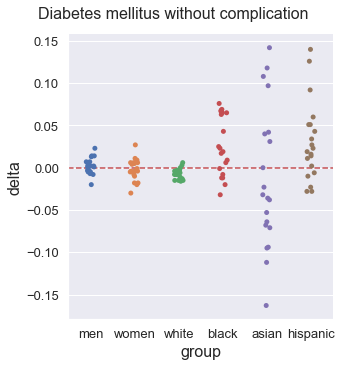

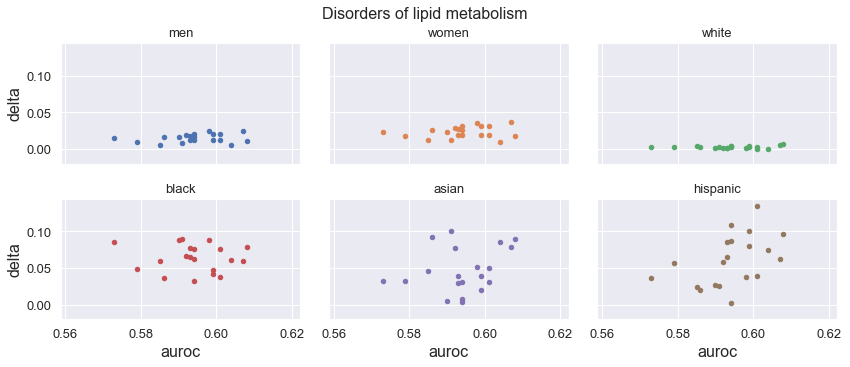

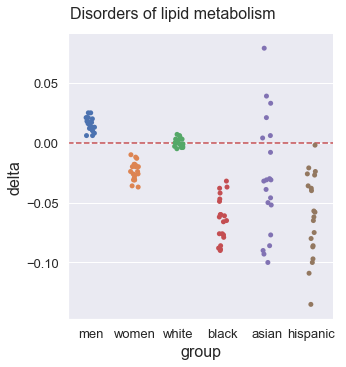

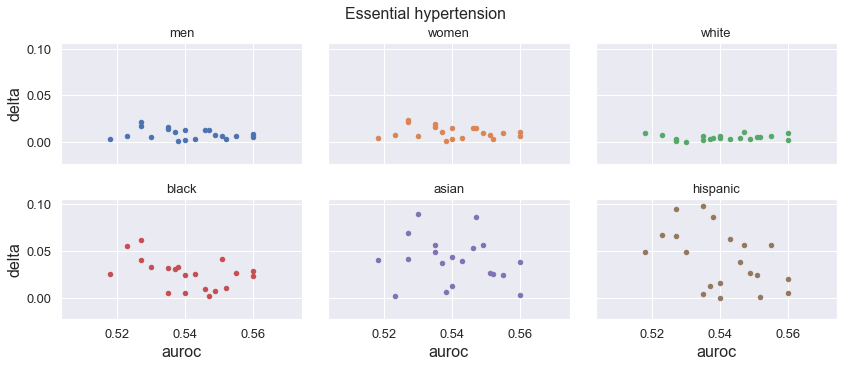

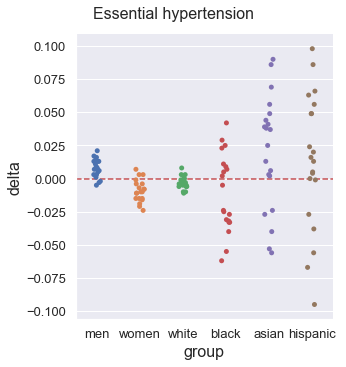

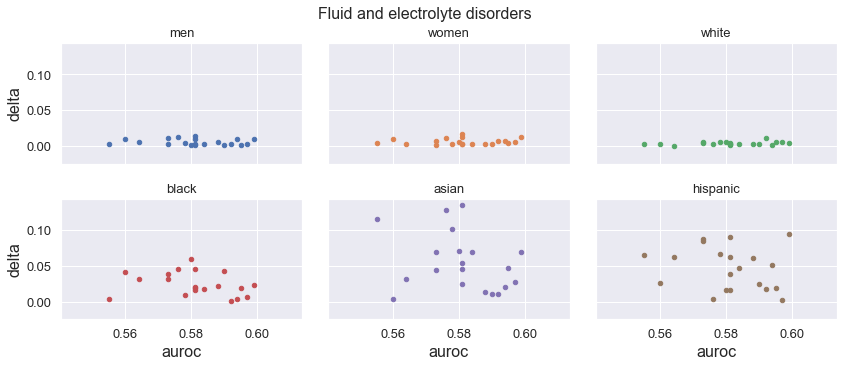

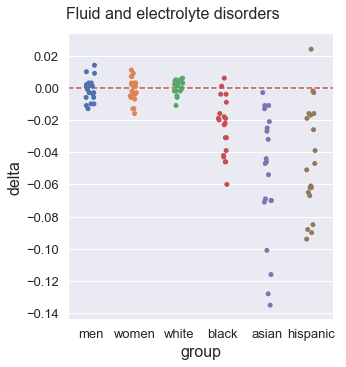

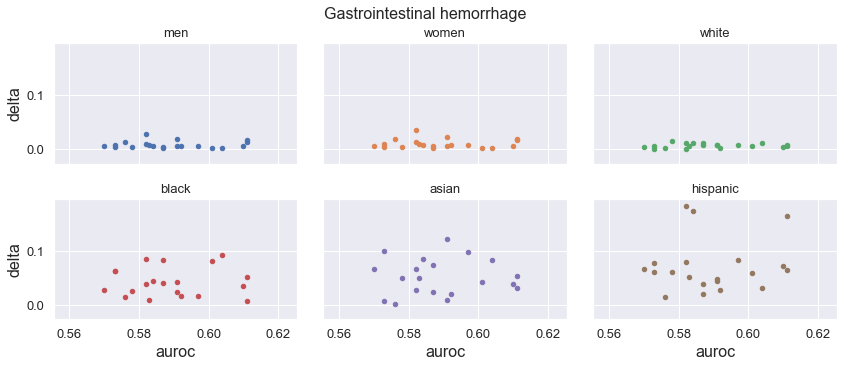

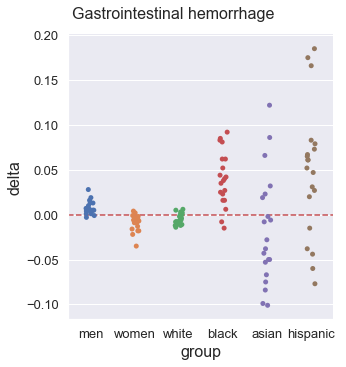

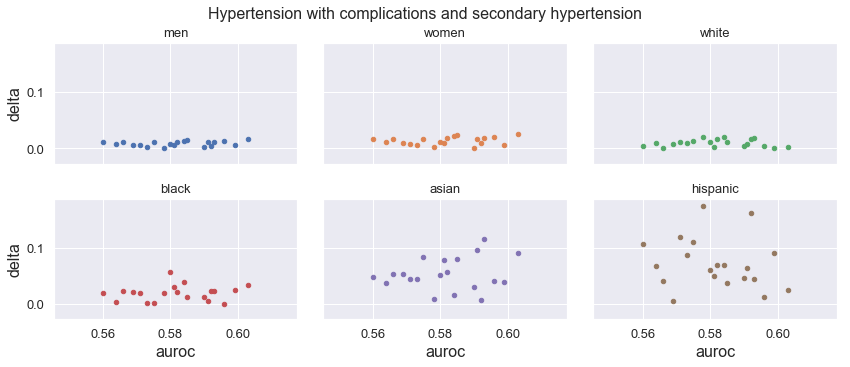

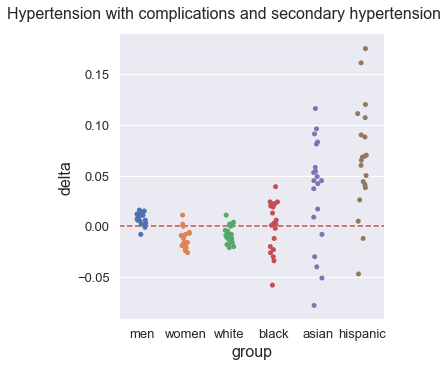

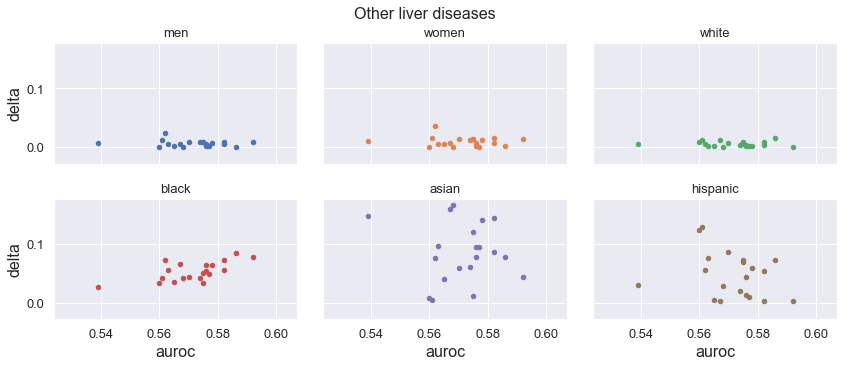

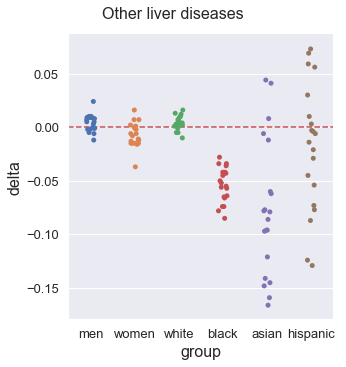

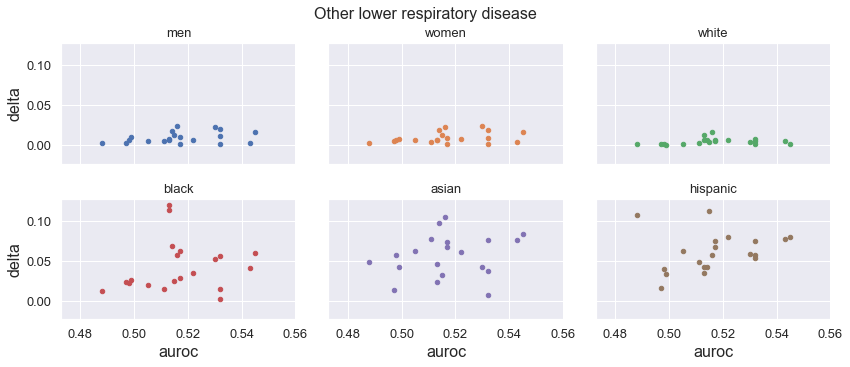

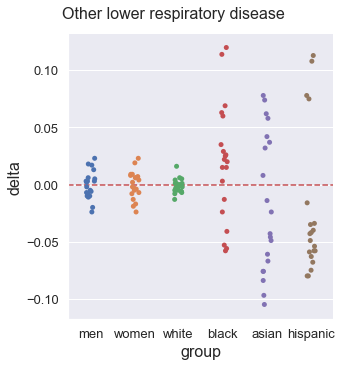

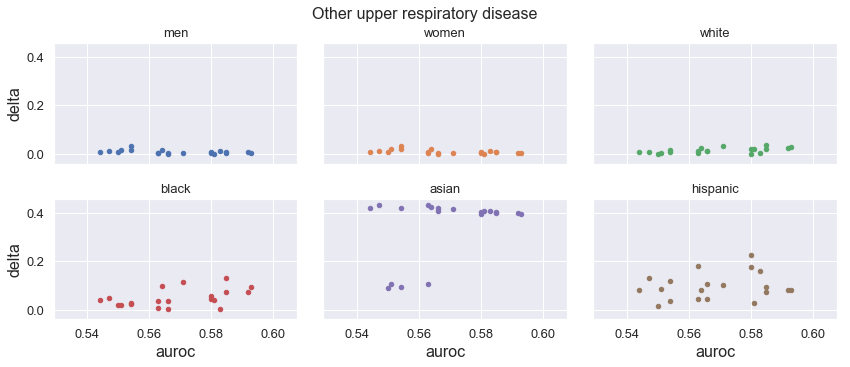

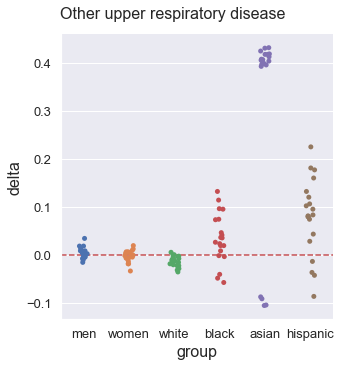

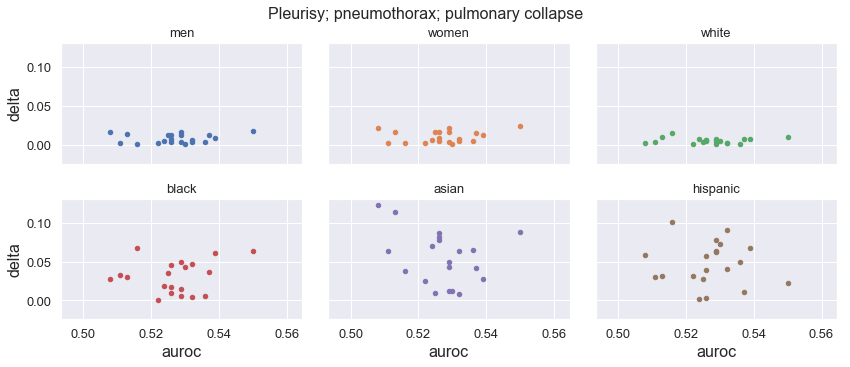

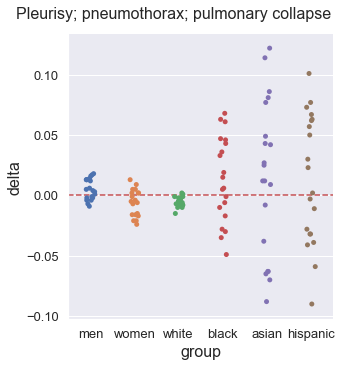

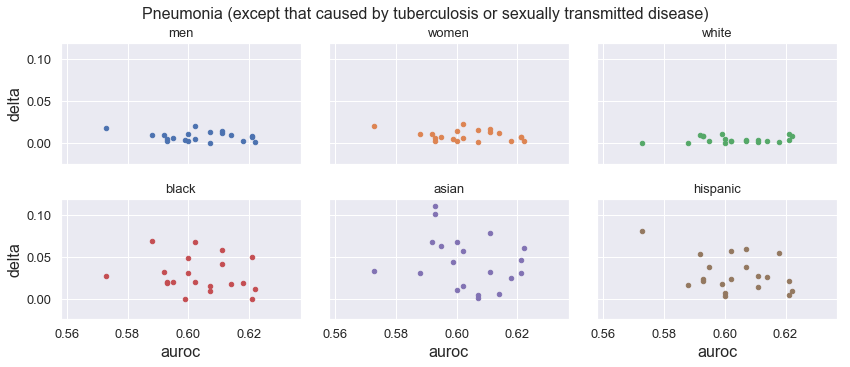

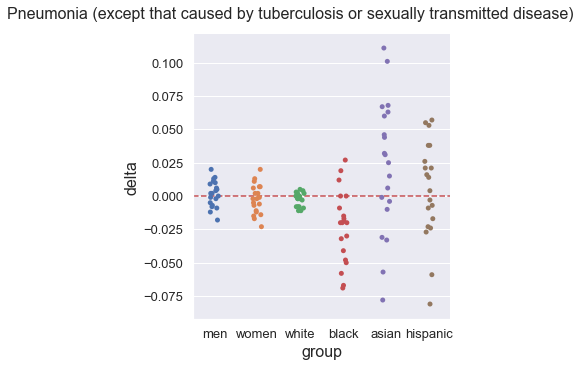

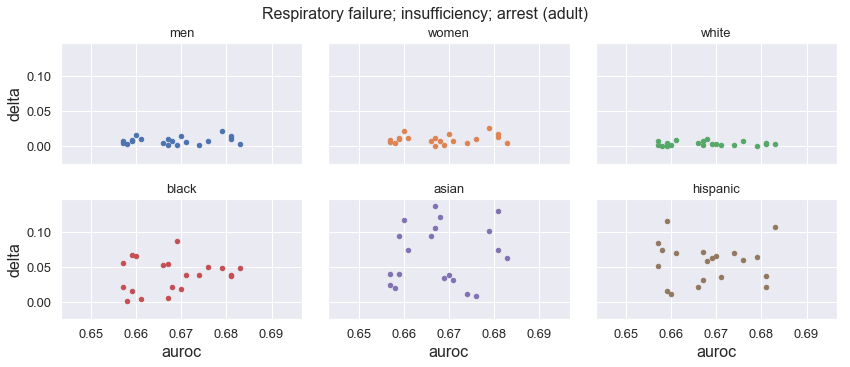

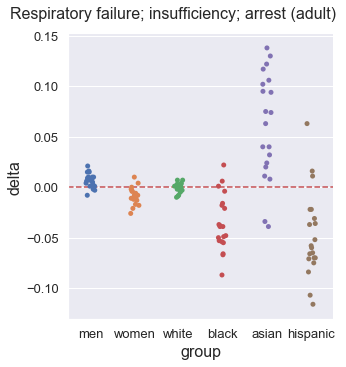

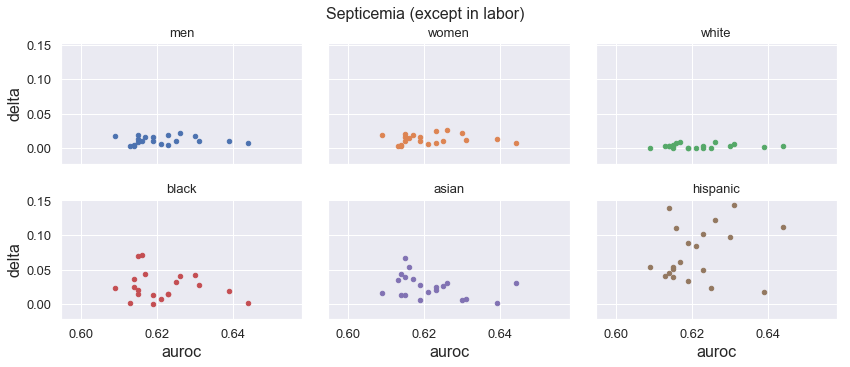

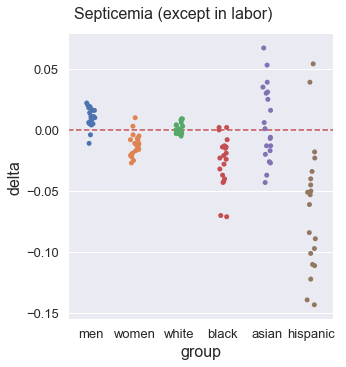

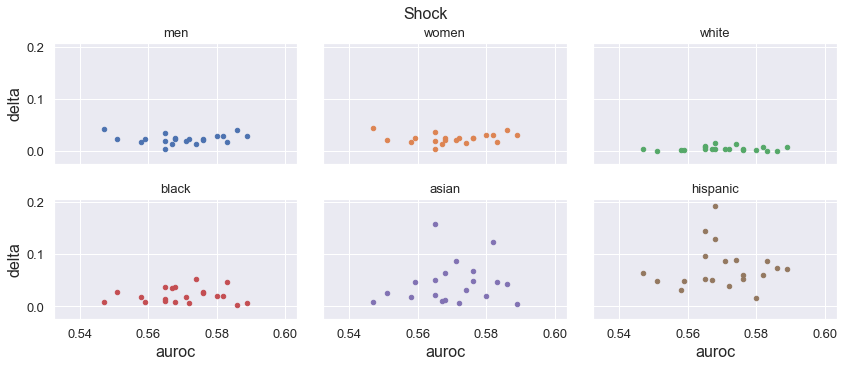

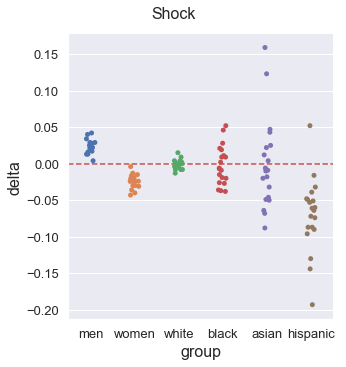

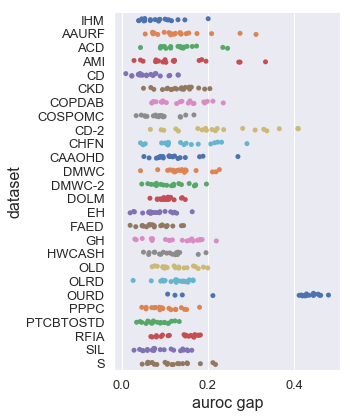

In [49]:
#plot tasks with fine tuning
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, TUNE_OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=PLOT_VAR)

In [ ]:
#Run tasks with tuning
TUNE_METRIC = "auprc"
run_tasks(INPUT_PATH+"tasks.txt", FEATURES_PATH, MODEL, TUNE_TMP_PATH, TUNE_OUTPUT_PATH, mini_tasks=True, reset=True, tune_metric=TUNE_METRIC)
# plot_tasks(INPUT_PATH, "tasks.txt", MODEL, TUNE_OUTPUT_PATH, mini_tasks=True, tune_metric=TUNE_METRIC)